In [26]:
import numpy as np 
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

# import folium # map rendering library
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

try:
    import folium
except:
    !pip install folium
    import folium

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [27]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'NS1BMN4IQNIXTELNFXESFX0URLAPABFZBW45DC1FBFZLXBUI' # your Foursquare ID
CLIENT_SECRET = '0NPFMHEGVT1KUBRIJLSVYFAFI33PPYQLI2HQ5X3YRSM0BYAF' # your Foursquare Secret
VERSION = '20180214' # Foursquare API version

## Define functions for this project

In [28]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [29]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [30]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    
    venue_data=results['response']['venue']
    venue_details=[]
    
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [31]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

## Use defined functions to get some initial data (NYC)

In [32]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [33]:
ny_data.shape  # number of different neighborhoods in NYC = 306

(306, 4)

## Analysis of the initial NYC data

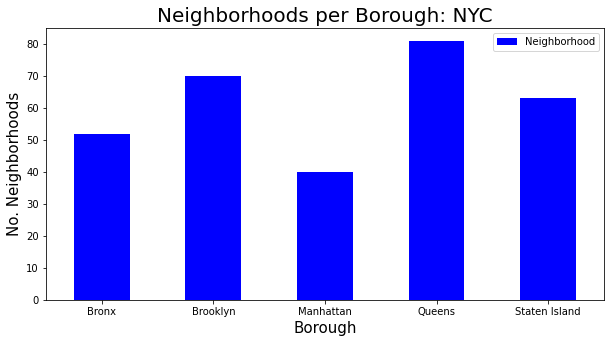

In [34]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

## Number of Japanese restaurants in each neighborhood and borough

In [35]:
# queens has most neighborhoods
# prepare neighborhood list that contains Japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

( 67 / 306 ) Japanese Restaurants in Carroll Gardens, Brooklyn:1
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Japanese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Japanese Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Japanese Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Japanese Restaurants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Japanese Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Japanese Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Japanese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758

( 130 / 306 ) Japanese Restaurants in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Japanese Restaurants in Woodside, Queens:1
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Japanese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Japanese Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Japanese Restaurants in Howard Beach, Queens:1
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Japanese Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Japanese Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Japanese Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Japan

( 196 / 306 ) Japanese Restaurants in North Corona, Queens:0
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Japanese Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Japanese Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Japanese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Japanese Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Japanese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Japanese Restaurants in West Brighton, Staten Island:1
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Japanese Restaurants in Grymes H

( 257 / 306 ) Japanese Restaurants in Randall Manor, Staten Island:0
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
( 258 / 306 ) Japanese Restaurants in Howland Hook, Staten Island:0
['Staten Island', 'Howland Hook', 40.63843283794795, -74.18622331749823]
( 259 / 306 ) Japanese Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Japanese Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Japanese Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Japanese Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Japanese Restaurants in Mill Basin, Brooklyn:2
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Japanese Restaurants in Jamaica Hills, Queens:0

In [36]:
# Save the information so far to japanese_rest_ny_tocsv1.csv due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.shape

(65, 4)

In [37]:
japanese_rest_ny.tail() # We found 65 Japanese restaurants across NYC

,Borough,Neighborhood,ID,Name
60,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
61,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
63,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
64,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


## Visualization of the results

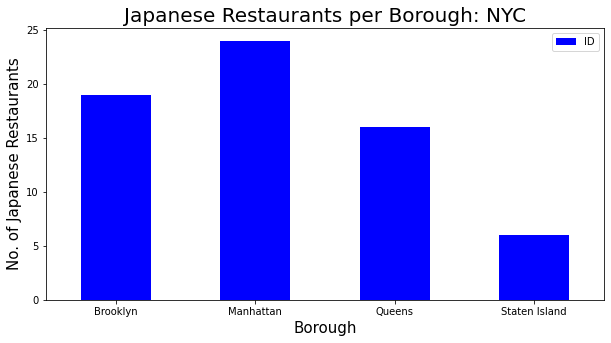

In [16]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### 1. Manhattan has the highest number of Japanese restaurants, dispite the fact that it has the least number of neighborhoods. 

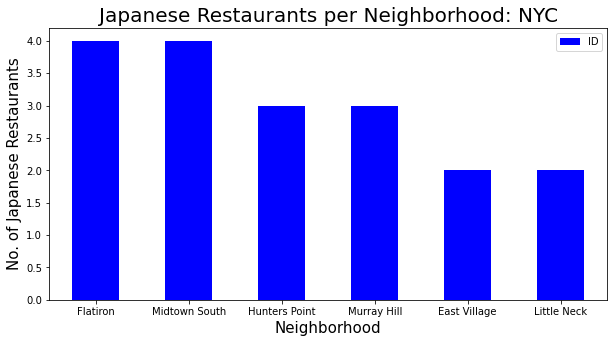

In [17]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### 2. The neighborhood of Flatiron and Midtown South have the highest number of Japanese restaurants in all of NYC.
### They are all located in the boroughs of Manhattan.

In [18]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
59,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
60,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
61,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


In [21]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Midtown South']

,Borough,Neighborhood,ID,Name
48,Manhattan,Midtown South,51e8ce40498ea1fb0180efb2,Izakaya MEW
49,Manhattan,Midtown South,57ab615d498eef084faa348b,Abiko Curry
50,Manhattan,Midtown South,5d7a9d59a369d40008dfcc1a,Konbini
51,Manhattan,Midtown South,58b8ed467220e661ddf34104,KazuNori: The Original Hand Roll Bar


## To better understand the distrubution, we need to look at the rating of each restaurant (yelp-like)

In [38]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # assign 0 value for no-data resturants
        id,name,likes,rating,tips=[0]*5
        
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
japanese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '602c4a81d203981fd4a9df17'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49, 'usersCount':

{'meta': {'code': 200, 'requestId': '602c4a8237228e39e8483141'}, 'response': {'venue': {'id': '51f9b7b3498eefe896caeb23', 'name': 'Shalom Japan', 'contact': {'phone': '7183884012', 'formattedPhone': '(718) 388-4012', 'twitter': 'shalomjapan'}, 'location': {'address': '310 S 4th St', 'crossStreet': 'at Rodney St', 'lat': 40.709219, 'lng': -73.955839, 'labeledLatLngs': [{'label': 'display', 'lat': 40.709219, 'lng': -73.955839}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['310 S 4th St (at Rodney St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shalom-japan/51f9b7b3498eefe896caeb23', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '52e81612bcbc57f1066b79fd', 'nam

{'meta': {'code': 200, 'requestId': '602c4a82dba4b9223d0c2e1c'}, 'response': {'venue': {'id': '479ccb47f964a5206b4d1fe3', 'name': 'Iron Chef House', 'contact': {'phone': '7188588517', 'formattedPhone': '(718) 858-8517', 'facebook': '115805155108798', 'facebookUsername': 'IronChefHouse', 'facebookName': 'Iron Chef House'}, 'location': {'address': '92 Clark St', 'crossStreet': 'Henry St', 'lat': 40.697405738767394, 'lng': -73.99256031665585, 'labeledLatLngs': [{'label': 'display', 'lat': 40.697405738767394, 'lng': -73.99256031665585}, {'label': 'entrance', 'lat': 40.69726, 'lng': -73.992604}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['92 Clark St (Henry St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/iron-chef-house/479ccb47f964a5206b4d1fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName'

{'meta': {'code': 200, 'requestId': '602c4a829671424fd39d2d58'}, 'response': {'venue': {'id': '48a41073f964a52091511fe3', 'name': 'Hibino', 'contact': {'phone': '7182608052', 'formattedPhone': '(718) 260-8052', 'twitter': 'hibino_brooklyn', 'facebook': '301149720034179', 'facebookUsername': 'hibinobklyn', 'facebookName': 'Hibino Brooklyn'}, 'location': {'address': '333 Henry St', 'crossStreet': 'at Pacific St', 'lat': 40.69007601730789, 'lng': -73.99649744997076, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69007601730789, 'lng': -73.99649744997076}, {'label': 'entrance', 'lat': 40.690164, 'lng': -73.996383}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['333 Henry St (at Pacific St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hibino/48a41073f964a52091511fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Rest

{'meta': {'code': 200, 'requestId': '602c4a832dbbf54b004aaa68'}, 'response': {'venue': {'id': '5739c66c498e7ef6085cec4f', 'name': 'Karasu', 'contact': {'phone': '3472234811', 'formattedPhone': '(347) 223-4811'}, 'location': {'address': '166 Dekalb Ave', 'lat': 40.68957739999216, 'lng': -73.97329032514342, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68957739999216, 'lng': -73.97329032514342}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['166 Dekalb Ave', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/karasu/5739c66c498e7ef6085cec4f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 35, 'usersCount': 0, 'checkinsCount': 0, 'vis

{'meta': {'code': 200, 'requestId': '602c4a8379dc4e799f756cc6'}, 'response': {'venue': {'id': '4e3cadcb1f6e844231dbe017', 'name': 'Waza', 'contact': {'phone': '7183999292', 'formattedPhone': '(718) 399-9292'}, 'location': {'address': '485 Myrtle Ave', 'lat': 40.693487522158414, 'lng': -73.965735666986, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693487522158414, 'lng': -73.965735666986}, {'label': 'entrance', 'lat': 40.693575, 'lng': -73.965731}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['485 Myrtle Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/waza/4e3cadcb1f6e844231dbe017', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'ti

{'meta': {'code': 200, 'requestId': '602c4a845c6a614aab4be986'}, 'response': {'venue': {'id': '58a202a25490d30f87553a08', 'name': 'Rice & Miso', 'contact': {'phone': '9292793488', 'formattedPhone': '(929) 279-3488', 'twitter': 'riceandmiso', 'instagram': 'riceandmisoeveryday'}, 'location': {'address': '134 Nevins St', 'lat': 40.68463349074915, 'lng': -73.9837684857605, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68463349074915, 'lng': -73.9837684857605}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['134 Nevins St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rice--miso/58a202a25490d30f87553a08', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 

{'meta': {'code': 200, 'requestId': '602c4a84debd87623f0a9763'}, 'response': {'venue': {'id': '4c7f0887fb74236a7727f9b9', 'name': 'Samurai Mama', 'contact': {'phone': '7185996161', 'formattedPhone': '(718) 599-6161'}, 'location': {'address': '205 Grand St', 'crossStreet': 'btwn Bedford & Driggs Ave', 'lat': 40.71411421938972, 'lng': -73.96019631848635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71411421938972, 'lng': -73.96019631848635}, {'label': 'entrance', 'lat': 40.714135, 'lng': -73.960149}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['205 Grand St (btwn Bedford & Driggs Ave)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/samurai-mama/4c7f0887fb74236a7727f9b9', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '602c4a85abee4e16a12962eb'}, 'response': {'venue': {'id': '4c2678eef1272d7f43a986c5', 'name': 'Fushimi', 'contact': {'phone': '7188337788', 'formattedPhone': '(718) 833-7788', 'twitter': 'fushimi_ny', 'facebook': '1885597118324660', 'facebookUsername': 'fushimibayridge', 'facebookName': 'Fushimi Japanese Cuisine & Lounge'}, 'location': {'address': '9316 4th Ave', 'crossStreet': 'btwn 93rd & 94th St', 'lat': 40.61727, 'lng': -74.03101, 'labeledLatLngs': [{'label': 'display', 'lat': 40.61727, 'lng': -74.03101}, {'label': 'entrance', 'lat': 40.61725, 'lng': -74.030831}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9316 4th Ave (btwn 93rd & 94th St)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fushimi/4c2678eef1272d7f43a986c5', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restauran

{'meta': {'code': 200, 'requestId': '602c4a8571ff1769d0ed2cbe'}, 'response': {'venue': {'id': '542efa85498ea11026c9746c', 'name': 'Kappo Masa', 'contact': {'phone': '2129067141', 'formattedPhone': '(212) 906-7141'}, 'location': {'address': '976 Madison Ave', 'crossStreet': '76th Street', 'lat': 40.77452684529511, 'lng': -73.96346606906828, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77452684529511, 'lng': -73.96346606906828}, {'label': 'entrance', 'lat': 40.774636, 'lng': -73.963525}], 'postalCode': '10075', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['976 Madison Ave (76th Street)', 'New York, NY 10075', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kappo-masa/542efa85498ea11026c9746c', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': 

{'meta': {'code': 200, 'requestId': '602c4a85c005d56f94a4560f'}, 'response': {'venue': {'id': '5aa1d85d5f68b931b6f5acda', 'name': 'Kome Waza UES', 'contact': {'phone': '6468385928', 'formattedPhone': '(646) 838-5928'}, 'location': {'address': '1275 1st Ave', 'crossStreet': '69th St', 'lat': 40.765601636058776, 'lng': -73.95740334822048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.765601636058776, 'lng': -73.95740334822048}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1275 1st Ave (69th St)', 'New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kome-waza-ues/5aa1d85d5f68b931b6f5acda', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1bd941735', 'nam

{'meta': {'code': 200, 'requestId': '602c4a86b9e8291154be3218'}, 'response': {'venue': {'id': '51fd77be498e883bf20fcca8', 'name': 'OOTOYA 大戸屋 (OOTOYA)', 'contact': {'phone': '2127040833', 'formattedPhone': '(212) 704-0833', 'twitter': 'ootoyany', 'facebook': '435716963171121', 'facebookUsername': 'Ootoyanyc', 'facebookName': 'OOTOYA NY'}, 'location': {'address': '141 W 41st St', 'crossStreet': 'btwn Broadway & 6th Ave', 'lat': 40.75497346338808, 'lng': -73.98610346565407, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75497346338808, 'lng': -73.98610346565407}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['141 W 41st St (btwn Broadway & 6th Ave)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ootoya-%E5%A4%A7%E6%88%B8%E5%B1%8B/51fd77be498e883bf20fcca8', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 's

{'meta': {'code': 200, 'requestId': '602c4a864dcfcc005ed5a43e'}, 'response': {'venue': {'id': '591caee89deb7d0f69be77a2', 'name': 'Omusubi Gonbei', 'contact': {'phone': '9174727168', 'formattedPhone': '(917) 472-7168'}, 'location': {'address': '370 Lexington Ave', 'crossStreet': '41st St', 'lat': 40.75092439033842, 'lng': -73.9769462752827, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75092439033842, 'lng': -73.9769462752827}], 'postalCode': '10017', 'cc': 'US', 'neighborhood': 'Midtown East', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['370 Lexington Ave (41st St)', 'New York, NY 10017', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/omusubi-gonbei/591caee89deb7d0f69be77a2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '602c4a86debd87623f0a9c9f'}, 'response': {'venue': {'id': '510c85e7e4b0056826b88297', 'name': 'Kura', 'contact': {'phone': '2122281010', 'formattedPhone': '(212) 228-1010'}, 'location': {'address': '130 Saint Marks Pl', 'crossStreet': 'btwn 1st Ave & Ave A', 'lat': 40.726802644699376, 'lng': -73.98344407523645, 'labeledLatLngs': [{'label': 'display', 'lat': 40.726802644699376, 'lng': -73.98344407523645}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['130 Saint Marks Pl (btwn 1st Ave & Ave A)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kura/510c85e7e4b0056826b88297', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48

{'meta': {'code': 200, 'requestId': '602c4a87debd87623f0a9d7c'}, 'response': {'venue': {'id': '535978ff498ec5450feaef85', 'name': 'Azasu', 'contact': {'phone': '2127777069', 'formattedPhone': '(212) 777-7069', 'twitter': 'azasunyc'}, 'location': {'address': '49 Clinton St', 'lat': 40.719627714039376, 'lng': -73.98480299175428, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719627714039376, 'lng': -73.98480299175428}, {'label': 'entrance', 'lat': 40.719711, 'lng': -73.984846}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49 Clinton St', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/azasu/535978ff498ec5450feaef85', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '602c4a87b2301614a40211af'}, 'response': {'venue': {'id': '56e8c670cd1017cb5460dc3f', 'name': 'Natsumi Tapas', 'contact': {'phone': '2128892182', 'formattedPhone': '(212) 889-2182'}, 'location': {'address': '323 3rd Ave', 'crossStreet': '24th Street', 'lat': 40.73964463941883, 'lng': -73.98257364976163, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73964463941883, 'lng': -73.98257364976163}], 'postalCode': '10019', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['323 3rd Ave (24th Street)', 'New York, NY 10019', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/natsumi-tapas/56e8c670cd1017cb5460dc3f', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCo

{'meta': {'code': 200, 'requestId': '602c4a8771ff1769d0ed32c6'}, 'response': {'venue': {'id': '4c100cd3b93cc9b6482156e0', 'name': 'Hagane', 'contact': {'phone': '7188358385', 'formattedPhone': '(718) 835-8385'}, 'location': {'address': '16102 Crossbay Blvd', 'crossStreet': '161st Ave', 'lat': 40.65578638078417, 'lng': -73.83910802522121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65578638078417, 'lng': -73.83910802522121}, {'label': 'entrance', 'lat': 40.655599, 'lng': -73.839269}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16102 Crossbay Blvd (161st Ave)', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hagane/4c100cd3b93cc9b6482156e0', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffi

{'meta': {'code': 200, 'requestId': '602c4a8841cc7e0fe97fbd7c'}, 'response': {'venue': {'id': '53696c9b498ef94c9f2bc134', 'name': 'Tei Nei Ya', 'contact': {'phone': '7188192158', 'formattedPhone': '(718) 819-2158'}, 'location': {'address': '25120 Northern Blvd', 'lat': 40.76933551580838, 'lng': -73.73662086699395, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76933551580838, 'lng': -73.73662086699395}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25120 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tei-nei-ya/53696c9b498ef94c9f2bc134', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 

{'meta': {'code': 200, 'requestId': '602c4a88abee4e16a1296c9b'}, 'response': {'venue': {'id': '50f5979fe4b0ff6d3603e506', 'name': 'PP Boy Japan Teriyaki & Sushi', 'contact': {}, 'location': {'address': '90-22 161st St', 'lat': 40.70489618401879, 'lng': -73.7990307819717, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70489618401879, 'lng': -73.7990307819717}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90-22 161st St', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pp-boy-japan-teriyaki--sushi/50f5979fe4b0ff6d3603e506', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'u

{'meta': {'code': 200, 'requestId': '602c4a898e5f3a382626f4f4'}, 'response': {'venue': {'id': '4c1868bb50389c74257fb3cf', 'name': "O'Sake Japanese Restaurant", 'contact': {'phone': '7189458888', 'formattedPhone': '(718) 945-8888', 'twitter': 'osakejapanese'}, 'location': {'address': '263 Beach 116th St', 'crossStreet': 'btw Newport Ave & Rockaway Beach Blvd', 'lat': 40.58112554862929, 'lng': -73.83797237571447, 'labeledLatLngs': [{'label': 'display', 'lat': 40.58112554862929, 'lng': -73.83797237571447}], 'postalCode': '11694', 'cc': 'US', 'city': 'Rockaway Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['263 Beach 116th St (btw Newport Ave & Rockaway Beach Blvd)', 'Rockaway Park, NY 11694', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/osake-japanese-restaurant/4c1868bb50389c74257fb3cf', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 

{'meta': {'code': 200, 'requestId': '602c4a8adba4b9223d0c40a4'}, 'response': {'venue': {'id': '4bca626368f976b086615f83', 'name': 'Kyoto Sushi 5', 'contact': {'phone': '7187276666', 'formattedPhone': '(718) 727-6666', 'twitter': 'kyotosushi5'}, 'location': {'address': '418 Forest Ave', 'crossStreet': 'Walbrooke Ave', 'lat': 40.63082355885339, 'lng': -74.10328887644148, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63082355885339, 'lng': -74.10328887644148}, {'label': 'entrance', 'lat': 40.630759, 'lng': -74.10329}], 'postalCode': '10301', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['418 Forest Ave (Walbrooke Ave)', 'Staten Island, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kyoto-sushi-5/4bca626368f976b086615f83', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/im

{'meta': {'code': 200, 'requestId': '602c4a8a0ac61561dc288986'}, 'response': {'venue': {'id': '4b9863e0f964a520a83f35e3', 'name': 'Tomo', 'contact': {'phone': '7182275100', 'formattedPhone': '(718) 227-5100'}, 'location': {'address': '4561 Amboy Rd', 'lat': 40.54301071166992, 'lng': -74.16570281982422, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54301071166992, 'lng': -74.16570281982422}], 'postalCode': '10312', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4561 Amboy Rd', 'Staten Island, NY 10312', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tomo/4b9863e0f964a520a83f35e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaurant', 'pluralName': 'Sushi

{'meta': {'code': 200, 'requestId': '602c4a8b55bb0c5d45e802d3'}, 'response': {'venue': {'id': '4b79eec8f964a520161b2fe3', 'name': 'Sapporo Sushi', 'contact': {'phone': '7189833781', 'formattedPhone': '(718) 983-3781'}, 'location': {'address': '1650 Richmond Ave', 'lat': 40.60797638050071, 'lng': -74.16345242968946, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60797638050071, 'lng': -74.16345242968946}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1650 Richmond Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sapporo-sushi/4b79eec8f964a520161b2fe3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d2941735', 'name': 'Sushi Restaur

{'meta': {'code': 200, 'requestId': '602c4a8be7297327cac05688'}, 'response': {'venue': {'id': '51e8ce40498ea1fb0180efb2', 'name': 'Izakaya MEW', 'contact': {'phone': '6463689384', 'formattedPhone': '(646) 368-9384', 'facebook': '141143689388266', 'facebookUsername': 'izakayamew', 'facebookName': 'Izakaya MEW'}, 'location': {'address': '53 W 35th St', 'crossStreet': 'btwn Avenue Of The Americas & 5th Ave', 'lat': 40.750145083699266, 'lng': -73.98639033818998, 'labeledLatLngs': [{'label': 'display', 'lat': 40.750145083699266, 'lng': -73.98639033818998}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['53 W 35th St (btwn Avenue Of The Americas & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/izakaya-mew/51e8ce40498ea1fb0180efb2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 

{'meta': {'code': 200, 'requestId': '602c4a8bd203981fd4a9f850'}, 'response': {'venue': {'id': '5d7a9d59a369d40008dfcc1a', 'name': 'Konbini', 'contact': {'instagram': 'konbininy'}, 'location': {'address': '312 5th Ave', 'crossStreet': 'W. 32nd St', 'lat': 40.747074, 'lng': -73.985931, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747074, 'lng': -73.985931}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['312 5th Ave (W. 32nd St)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/konbini/5d7a9d59a369d40008dfcc1a', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16a941735', 'name': 'Bakery', 'pluralName': 'Bakeries', 'shortName': 'Bakery', 'icon': {'pr

{'meta': {'code': 200, 'requestId': '602c4a8c55bb0c5d45e80586'}, 'response': {'venue': {'id': '4d7fc91f95c1a143260eecf2', 'name': 'Yoshi', 'contact': {}, 'location': {'address': 'Ave T', 'crossStreet': 'E. 59th St', 'lat': 40.615668413926294, 'lng': -73.91805552591212, 'labeledLatLngs': [{'label': 'display', 'lat': 40.615668413926294, 'lng': -73.91805552591212}], 'postalCode': '11234', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Ave T (E. 59th St)', 'Brooklyn, NY 11234', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yoshi/4d7fc91f95c1a143260eecf2', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7, 'usersCount': 0, 'checkinsCount': 0, 'visitsCount': 0}, 'price': {'tier': 2

{'meta': {'code': 200, 'requestId': '602c4a8c078f3e56b8b21046'}, 'response': {'venue': {'id': '4b817770f964a520ffa730e3', 'name': 'Futigi Japanese Cuisine', 'contact': {'phone': '7183808878', 'formattedPhone': '(718) 380-8878'}, 'location': {'address': '16404 69th Ave', 'lat': 40.73306038089495, 'lng': -73.80471980881454, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73306038089495, 'lng': -73.80471980881454}], 'postalCode': '11365', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16404 69th Ave', 'Fresh Meadows, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/futigi-japanese-cuisine/4b817770f964a520ffa730e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7

{'meta': {'code': 200, 'requestId': '602c4a8c051c9e6616d1c9b8'}, 'response': {'venue': {'id': '5718e217498e458de03e94c8', 'name': 'Takumen', 'contact': {'phone': '7183617973', 'formattedPhone': '(718) 361-7973'}, 'location': {'address': '5-50 50th Ave', 'crossStreet': '50th Ave and Vernon Blvd', 'lat': 40.74278596085972, 'lng': -73.95454383115116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74278596085972, 'lng': -73.95454383115116}], 'postalCode': '11101', 'cc': 'US', 'neighborhood': 'Hunters Point', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5-50 50th Ave (50th Ave and Vernon Blvd)', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/takumen/5718e217498e458de03e94c8', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png

{'meta': {'code': 200, 'requestId': '602c4a8c01bac51bb1f3244e'}, 'response': {'venue': {'id': '5bb7e3ced48ec100398ab4fb', 'name': 'Dai Hachi', 'contact': {'phone': '7182556260', 'formattedPhone': '(718) 255-6260'}, 'location': {'address': '46-18 Vernon Blvd', 'crossStreet': '46 Road', 'lat': 40.746355, 'lng': -73.953215, 'labeledLatLngs': [{'label': 'display', 'lat': 40.746355, 'lng': -73.953215}, {'label': 'entrance', 'lat': 40.74632, 'lng': -73.953039}], 'postalCode': '11101', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['46-18 Vernon Blvd (46 Road)', 'New York, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dai-hachi/5bb7e3ced48ec100398ab4fb', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified':

{'meta': {'code': 200, 'requestId': '602c4a8de7297327cac05bb7'}, 'response': {'venue': {'id': '5bd7a5561c675b0039be9acc', 'name': 'HALL', 'contact': {}, 'location': {'address': '17 W 20th St', 'crossStreet': '6th Ave', 'lat': 40.74026030891992, 'lng': -73.99232433068579, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74026030891992, 'lng': -73.99232433068579}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['17 W 20th St (6th Ave)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hall/5bd7a5561c675b0039be9acc', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d4941735', 'name': 'Speakeasy', 'pluralName': 'Speakeasies', 'shortName': 'Speakeasy', 'icon

{'meta': {'code': 200, 'requestId': '602c4a8d01bac51bb1f326a6'}, 'response': {'venue': {'id': '581a10901df6b32e66ec3a07', 'name': 'Sugarfish', 'contact': {'phone': '3477058100', 'formattedPhone': '(347) 705-8100', 'twitter': 'sugarfish', 'facebook': '33004696760', 'facebookUsername': 'sugarfishsushi', 'facebookName': 'SUGARFISH by sushi nozawa'}, 'location': {'address': '33 E 20th St', 'crossStreet': 'btwn Broadway & Park Ave S', 'lat': 40.7389505411552, 'lng': -73.98895476288, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7389505411552, 'lng': -73.98895476288}, {'label': 'entrance', 'lat': 40.738909, 'lng': -73.988893}], 'postalCode': '10003', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33 E 20th St (btwn Broadway & Park Ave S)', 'New York, NY 10003', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sugarfish/581a10901df6b32e66ec3a07', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', '

{'meta': {'code': 200, 'requestId': '602c4a8ebf8e526ca0166426'}, 'response': {'venue': {'id': '4ba2a9cbf964a520d00d38e3', 'name': 'Oki Japanese Restaurant', 'contact': {'phone': '7187293666', 'formattedPhone': '(718) 729-3666'}, 'location': {'address': '45-11 Queens Blvd', 'lat': 40.743311795775135, 'lng': -73.91904142185976, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743311795775135, 'lng': -73.91904142185976}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45-11 Queens Blvd', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/oki-japanese-restaurant/4ba2a9cbf964a520d00d38e3', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
60,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA),1221,9.1,274
61,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish,459,9.0,103
62,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago,158,8.6,26
63,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant,11,7.7,5
64,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou,12,7.8,1


In [39]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv')

In [40]:
japanese_rest_stats_ny.shape # We got statistics for all 65 Japanese Restaurants in New York city.

(65, 7)

In [41]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     object 
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     object 
dtypes: float64(1), object(6)
memory usage: 3.7+ KB


## Convert "Likes" & "Tips" from string to float 

In [42]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       65 non-null     object 
 1   Neighborhood  65 non-null     object 
 2   ID            65 non-null     object 
 3   Name          65 non-null     object 
 4   Likes         65 non-null     float64
 5   Rating        65 non-null     float64
 6   Tips          65 non-null     float64
dtypes: float64(3), object(4)
memory usage: 3.7+ KB


In [43]:
japanese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,65.000000,65.000000,65.000000
mean,151.692308,7.501538,45.369231
std,259.202076,2.317157,73.778928
min,0.000000,0.000000,0.000000
25%,12.000000,7.500000,5.000000
50%,41.000000,8.100000,12.000000
75%,182.000000,8.800000,52.000000
max,1221.000000,9.300000,353.000000


In [44]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Flatiron
ID              4f7b61f6e4b07aaa5d524842
Name                 OOTOYA 大戸屋 (OOTOYA)
Likes                               1221
Rating                               9.1
Tips                                 274
Name: 60, dtype: object

In [45]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              5b3805910dd31f002409405a
Name                          Suki Curry
Likes                                 56
Rating                               9.3
Tips                                  15
Name: 26, dtype: object

In [46]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                793
Rating                               8.9
Tips                                 353
Name: 24, dtype: object

## Visualize neighborhood with the max average rating of restaurants

In [47]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
10,East Village,9.200000
8,Cobble Hill,9.100000
21,Hunters Point,9.066667
12,Flatiron,8.975000
34,North Side,8.900000
6,Chelsea,8.900000
9,Downtown,8.900000
25,Lindenwood,8.800000
1,Boerum Hill,8.800000
35,Park Slope,8.800000


In [48]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.500000
0,Brooklyn,7.757895
2,Queens,6.312500
3,Staten Island,5.866667


## neighborhoods with an average rating>=8.0 is going to be a promising location

In [49]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.300000
1,Boerum Hill,8.800000
2,Brooklyn Heights,8.100000
4,Carroll Gardens,8.000000
6,Chelsea,8.900000
8,Cobble Hill,9.100000
9,Downtown,8.900000
10,East Village,9.200000
12,Flatiron,8.975000
13,Fort Greene,8.700000


In [50]:
#join this Dataset to original New York data to get longitude and latitude

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.300000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.800000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.100000
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.000000
4,Manhattan,Chelsea,40.744035,-74.003116,8.900000
5,Staten Island,Chelsea,40.594726,-74.189560,8.900000
6,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
7,Brooklyn,Downtown,40.690844,-73.983463,8.900000
8,Manhattan,East Village,40.727847,-73.982226,9.200000
9,Manhattan,Flatiron,40.739673,-73.990947,8.975000


In [51]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [52]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)